# DETECTING WORN-OUT TYRES USING EDGE DETECTION IN CNN.

In [1]:
#Importing all the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
import cv2
import os
import itertools
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
from tensorflow import keras 
from tensorflow.keras import layers 
import pandas as pd 
from datetime import datetime
import matplotlib.image as mpimg

# PREPROCESSING

In [2]:
#specifying the training and test data path
train_datapath = r'C:\Users\Dell_Laptop\Downloads\Tire_detection\Tire Textures\training_data'
validation_datapath = r'C:\Users\Dell_Laptop\Downloads\Tire_detection\Tire Textures\testing_data'
test_datapath = r'C:\Users\Dell_Laptop\Downloads\Tire_detection\Tire Textures\test_images'

In [3]:
cracked_path=train_datapath+'\cracked'
normal_path=train_datapath+'\normal'

The cell of code below was used to create cracked images as part of data augmentation. 
It was an offshoot of the train datapath. It is hashed out here because I didn't want to run it again.
The output is "files created: 981"

In [4]:
# # Loop through the original images and apply the data augmentation to create images of cracked tyres
# dest_dir=r'C:\Users\Dell_Laptop\Downloads\Tire_detection\Tire Textures\aug_imgs\cracked'
# start_time = datetime.now()
# file_num=0
# for filename in os.listdir(cracked_path):
#     if filename.endswith('.jpg'):# check that file is a jpg file
#         img_path = os.path.join(cracked_path, filename)
#         img = load_img(img_path)
#         x = img_to_array(img)
#         x = x.reshape((1,) + x.shape)
#         i = 0
        
#         #save each augmented instance of the images in directory
#         for batch in datagen.flow(x, batch_size=1,
#                                   save_to_dir=dest_dir,
#                                   save_prefix=filename[:-4],
#                                   save_format='jpg'):
#             file_num+=1
#             print(f'files created: {file_num}',end='\r', flush=True)
#             i += 1
#             if i == 3:# Set the number of augmented images per original image
#                 break

Code below created a folder of normal tyres. output is "files created: 1128"

In [5]:
# # Loop through the original images and apply the data augmentation to create images of normal tyres
# dest_dir=r'C:/Users/Dell_Laptop/Downloads/Tire_detection/Tire Textures/aug_imgs/normal'
# start_time = datetime.now()
# file_num=0
# normal_path = 'C:/Users/Dell_Laptop/Downloads/Tire_detection/Tire Textures/training_data/normal'

# for filename in os.listdir(normal_path):
#     if filename.endswith('.jpg'):
#         img_path = os.path.join(normal_path, filename)
#         img = load_img(img_path)
#         x = img_to_array(img)
#         x = x.reshape((1,) + x.shape)
#         i = 0
        
#         #save each augmented instance of the images in directory
#         for batch in datagen.flow(x, batch_size=1,
#                                   save_to_dir=dest_dir,
#                                   save_prefix=filename[:-4],
#                                   save_format='jpg'):
#             file_num+=1
#             print(f'files created: {file_num}',end='\r', flush=True)
#             i += 1
#             if i == 3:# Set the number of augmented images per original image
#                 break

In [6]:
#declaring the new training datapath
dataset_dir= r'C:\Users\Dell_Laptop\Downloads\Tire_detection\Tire Textures\aug_imgs'

Here we apply Canny edge detection to all images in a directory and saves the edge-detected images.

In [7]:
import cv2
import os

def apply_canny_edge_detection(dataset_dir, threshold1=100, threshold2=200):
    
    # Loop through all files in the directory
    for filename in os.listdir(dataset_dir):
        # Check if the file is an image file (e.g., JPEG, PNG, etc.)
        if filename.endswith(".jpg") or filename.endswith(".png"):
            # Read the image
            img_path = os.path.join(dataset_dir, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            # Applying Canny edge detection
            edges = cv2.Canny(img, threshold1, threshold2)

            # Saving the edge-detected image
            edge_filename = "edge_" + filename
            edge_img_path = os.path.join(dataset_dir, edge_filename)
            cv2.imwrite(edge_img_path, edges)

            print(f"Applied Canny edge detection to {filename} and saved the result as {edge_filename}.")

Let us now take a view of how the code above has affected our images. We will check the original image and the image after edge detection has been applied.

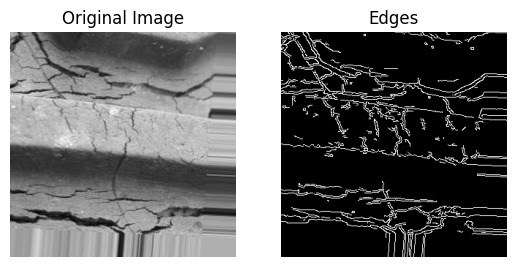

In [8]:
import cv2
import matplotlib.pyplot as plt

# Load the image in grayscale mode
image_path = r'C:\Users\Dell_Laptop\Downloads\Tire_detection\Tire Textures\aug_imgs\cracked\Cracked-9_0_9039.jpg'
edge_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Apply Canny edge detection
edges = cv2.Canny(edge_img, 100, 200)  

# Normalize pixel values to the range [0, 1]
edge_img_norm = edge_img / 255.0

# Display the original image
plt.subplot(1, 2, 1)
plt.imshow(edge_img_norm, cmap='gray')
plt.axis('off')
plt.title('Original Image')

# Display the image with edges
plt.subplot(1, 2, 2)
plt.imshow(edges, cmap='gray')
plt.axis('off')
plt.title('Edges')

plt.show()



In [9]:
from keras.preprocessing.image import ImageDataGenerator

In [10]:
# Here we are applying our desired transformations
train_gen = ImageDataGenerator(
        rescale=1./255, #1/255, # scales the image
        shear_range=0.2, # crops part of the image
        zoom_range=0.2, #zooms the image by 20%
        preprocessing_function=apply_canny_edge_detection(dataset_dir, threshold1=100, threshold2=200),
        horizontal_flip=True) # Secifies the horizontal flip


test_gen = ImageDataGenerator(
       rescale=1./255)


In [11]:
# Define the parameters for data augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [12]:
#specifying the train, validation and test generators

train_generator = train_gen.flow_from_directory(
        directory=dataset_dir,
        target_size=(150, 150),
        shuffle=True,
        batch_size=32,
        class_mode='binary')


validation_generator = test_gen.flow_from_directory(
        directory=validation_datapath,
        target_size=(150, 150),
        batch_size=1,
        shuffle=False,
        class_mode='binary')

test_generator = test_gen.flow_from_directory(
        directory=test_datapath,
        target_size=(150, 150),
        #batch_size=32,
        shuffle=False,
        class_mode=None)

Found 2108 images belonging to 2 classes.
Found 325 images belonging to 2 classes.
Found 14 images belonging to 1 classes.


# MODEL CREATION

CUSTOM MODEL 1

We will now create our baseline models and call them 'Custom Model 1' and 'Custom Model 2'. They will be compared with the performance of a pretrained model, VGG16.

In [13]:
#Call back setup
mc = ModelCheckpoint(filepath='./base_model.h5',
                     monitor='val_accuracy',
                     verbose=1,
                     save_best_only=True)

es = EarlyStopping(monitor='val_accuracy',
                   min_delta=0.01,
                   patience=5,
                   verbose=1)
cb = [mc,es]

In [14]:
#building the first model with four Conv2D layers, dropout and dense layers
model = models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(2, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [16]:
model.compile(optimizer='adam', loss= 'sparse_categorical_crossentropy', metrics='accuracy')

In [17]:
#Training the model, taking note of the duration of training

begintime = datetime.now()
history = model.fit(train_generator,epochs = 20, validation_data = validation_generator, callbacks = cb)
completetime = datetime.now()
duration = completetime - begintime
print(duration)

Epoch 1/20
66/66 [==============================] - ETA: 0s - loss: 0.6945 - accuracy: 0.5769
Epoch 1: val_accuracy improved from -inf to 0.61846, saving model to .\base_model.h5
66/66 [==============================] - 64s 948ms/step - loss: 0.6945 - accuracy: 0.5769 - val_loss: 0.6911 - val_accuracy: 0.6185
Epoch 2/20
66/66 [==============================] - ETA: 0s - loss: 0.6576 - accuracy: 0.6001
Epoch 2: val_accuracy improved from 0.61846 to 0.63385, saving model to .\base_model.h5
66/66 [==============================] - 64s 972ms/step - loss: 0.6576 - accuracy: 0.6001 - val_loss: 0.6329 - val_accuracy: 0.6338
Epoch 3/20
66/66 [==============================] - ETA: 0s - loss: 0.6231 - accuracy: 0.6475
Epoch 3: val_accuracy did not improve from 0.63385
66/66 [==============================] - 65s 989ms/step - loss: 0.6231 - accuracy: 0.6475 - val_loss: 0.7105 - val_accuracy: 0.5692
Epoch 4/20
66/66 [==============================] - ETA: 0s - loss: 0.6063 - accuracy: 0.6575
Epoc

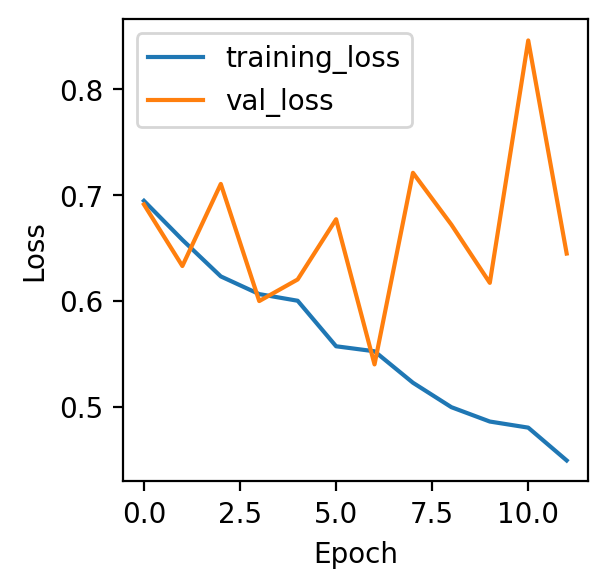

In [18]:
## checking for overfitting
history_df = pd.DataFrame(history.history)
plt.figure(dpi=200, figsize = (3,3))
plt.plot(history_df['loss'],
label='training_loss')
plt.plot(history_df['val_loss'],
label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

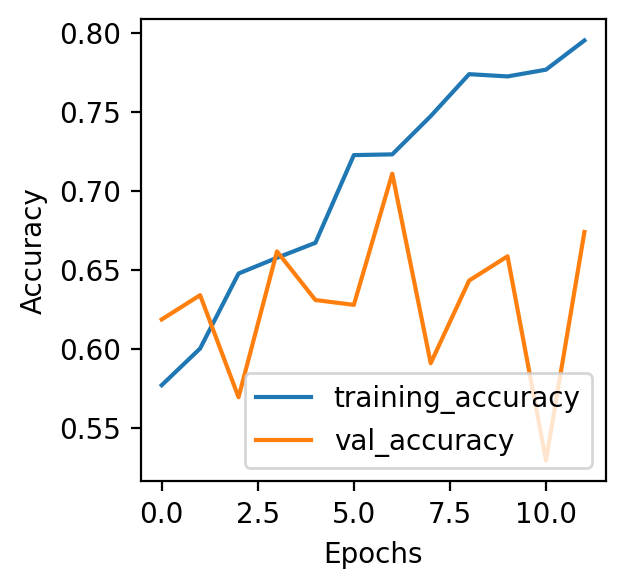

In [19]:
## checking for overfitting
history_df = pd.DataFrame(history.history)
plt.figure(dpi=200, figsize = (3,3))
plt.plot(history_df['accuracy'],
label='training_accuracy')
plt.plot(history_df['val_accuracy'],
label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
#defining the prediction
predictions = model.predict(x = validation_generator, verbose = 0)

In [21]:
predictions = np.argmax(predictions, axis=1)

In [22]:
#generating the confusion matrix. TP, FP, TN, FN
cm = confusion_matrix(y_true = validation_generator.classes, y_pred = predictions)
cm

array([[145,  65],
       [ 41,  74]], dtype=int64)

In [26]:
y_true = validation_generator.classes

In [27]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

              precision    recall  f1-score   support

           0       0.78      0.69      0.73       210
           1       0.53      0.64      0.58       115

    accuracy                           0.67       325
   macro avg       0.66      0.67      0.66       325
weighted avg       0.69      0.67      0.68       325



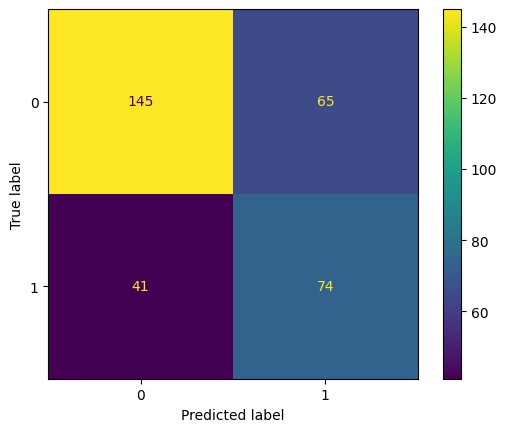

In [29]:
#Creating the classification report and a plot of the confusion matrix
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, plot_roc_curve,roc_auc_score)
Confusion_mat = ConfusionMatrixDisplay(cm)
print(classification_report(y_true, predictions))
Confusion_mat.plot()

# CUSTOM MODEL 2

In [83]:
#building the Second model with increased Conv2D layers, dropout isn't included and dense layers are added

model2 = models.Sequential()
model2.add(layers.Conv2D(32,(3,3),activation='relu', input_shape=(150,150,3)))
# model2.add(layers.MaxPooling2D((2,2)))
# model2.add(layers.Conv2D(32,(3,3),activation='relu'))
# model2.add(layers.MaxPooling2D((2,2)))
# model2.add(layers.Conv2D(64,(3,3),activation='relu'))
# model2.add(layers.MaxPooling2D((2,2)))
# model2.add(layers.Conv2D(128,(3,3),activation='relu'))
# model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(256,(3,3),activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(2, activation='softmax'))

In [84]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 conv2d_10 (Conv2D)          (None, 146, 146, 256)     73984     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 73, 73, 256)      0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1364224)           0         
                                                                 
 dense_6 (Dense)             (None, 64)                87310400  
                                                                 
 dense_7 (Dense)             (None, 2)                 130       
                                                      

In [ ]:
#Call back setup
mc = ModelCheckpoint(filepath='./base_model.h5',
                     monitor='val_accuracy',
                     verbose=1,
                     save_best_only=True)

es = EarlyStopping(monitor='val_accuracy',
                   min_delta=0.01,
                   patience=5,
                   verbose=1)
cb = [mc,es]

In [85]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [86]:
#Training the model, taking note of the duration of training

begintime = datetime.now()
history2 = model2.fit(train_generator, epochs = 20, validation_data = validation_generator, callbacks = cb)
completetime = datetime.now()
duration = completetime - begintime
print(duration)

Epoch 1/20
66/66 [==============================] - ETA: 0s - loss: 1.5477 - accuracy: 0.5825
Epoch 1: val_accuracy did not improve from 0.76000
66/66 [==============================] - 277s 4s/step - loss: 1.5477 - accuracy: 0.5825 - val_loss: 0.7693 - val_accuracy: 0.5600
Epoch 2/20
66/66 [==============================] - ETA: 0s - loss: 0.6341 - accuracy: 0.6452
Epoch 2: val_accuracy did not improve from 0.76000
66/66 [==============================] - 280s 4s/step - loss: 0.6341 - accuracy: 0.6452 - val_loss: 0.6327 - val_accuracy: 0.6923
Epoch 3/20
66/66 [==============================] - ETA: 0s - loss: 0.6267 - accuracy: 0.6580
Epoch 3: val_accuracy did not improve from 0.76000
66/66 [==============================] - 280s 4s/step - loss: 0.6267 - accuracy: 0.6580 - val_loss: 0.6261 - val_accuracy: 0.6769
Epoch 4/20
66/66 [==============================] - ETA: 0s - loss: 0.5859 - accuracy: 0.6822
Epoch 4: val_accuracy did not improve from 0.76000
66/66 [=======================

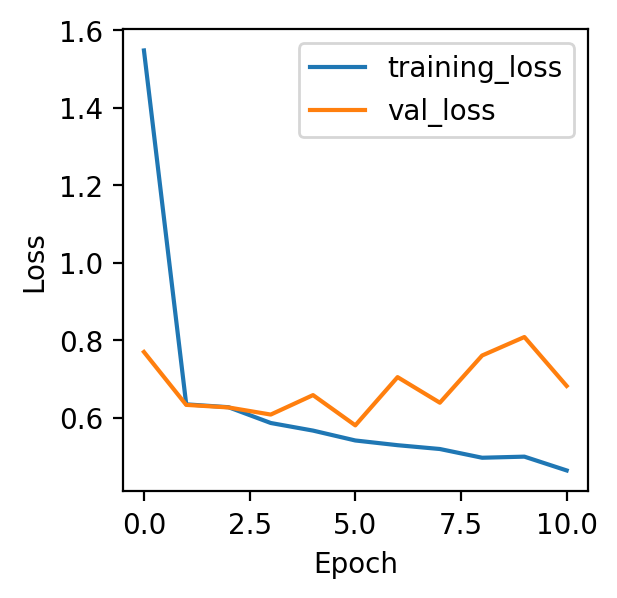

In [87]:
## checking for overfitting
history1_df = pd.DataFrame(history2.history)
plt.figure(dpi=200, figsize = (3,3))
plt.plot(history1_df['loss'],
label='training_loss')
plt.plot(history1_df['val_loss'],
label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

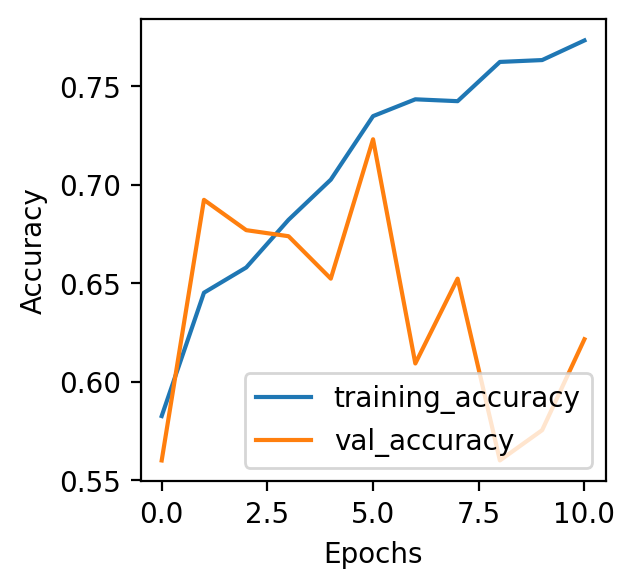

In [88]:
## checking for overfitting
history1_df = pd.DataFrame(history2.history)
plt.figure(dpi=200, figsize = (3,3))
plt.plot(history1_df['accuracy'],
label='training_accuracy')
plt.plot(history1_df['val_accuracy'],
label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [89]:
predictions2 = model2.predict(x = validation_generator, verbose = 0)

In [90]:
predictions2 = np.argmax(predictions2, axis=1)

In [91]:
#generating the confusion matrix. TP, FP, TN, FN

cm1 = confusion_matrix(y_true = validation_generator.classes, y_pred = predictions2)
cm1

array([[109, 101],
       [ 22,  93]], dtype=int64)

              precision    recall  f1-score   support

           0       0.83      0.52      0.64       210
           1       0.48      0.81      0.60       115

    accuracy                           0.62       325
   macro avg       0.66      0.66      0.62       325
weighted avg       0.71      0.62      0.63       325



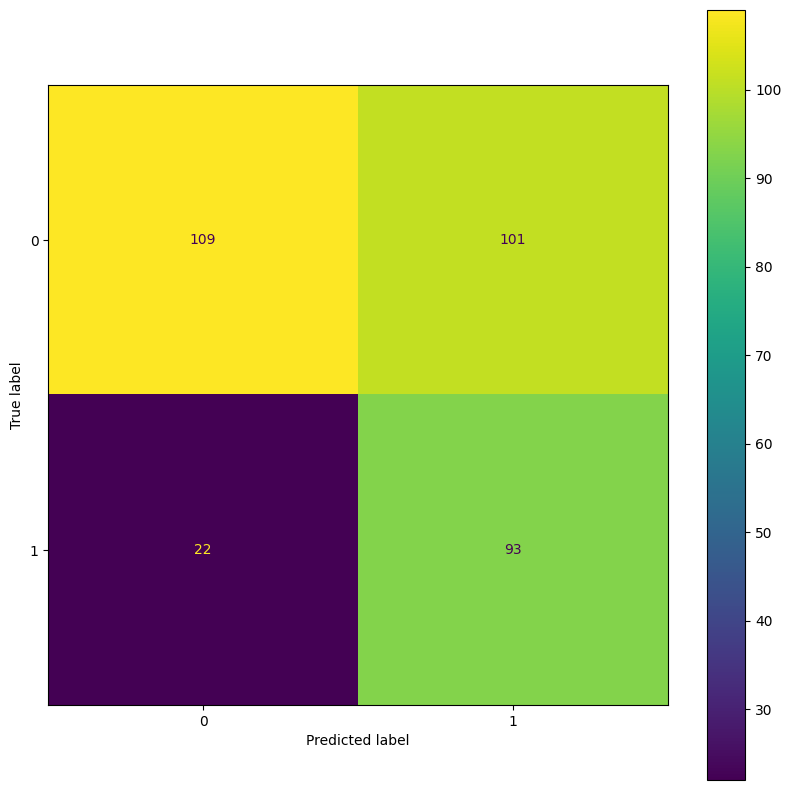

In [92]:
#Creating the classification report and a plot of the confusion matrix

from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, plot_roc_curve,roc_auc_score)
Confusion_mat1 = ConfusionMatrixDisplay(cm1)
print(classification_report(y_true, predictions2))
Confusion_mat1.plot()

# TRANSFER LEARNING: VGG16

In [40]:
#Defining the parameters
vgg = VGG16(input_shape = (150,150,3), weights = 'imagenet', include_top = False)

for layer in vgg.layers:
    layer.trainable = False
    
x = layers.Flatten()(vgg.output)
x = layers.Dense(512, activation = 'relu')(x) 
#x = layers.Dense(1024, activation = 'relu')(x) 
x = layers.Dense(2, activation='softmax')(x)

model3 = Model(inputs = vgg.input, outputs = x)

In [41]:
model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')

In [42]:
#Call back setup
mc1 = ModelCheckpoint(filepath='./base_model.h5',
                     monitor='accuracy',
                     verbose=1,
                     save_best_only=True)

esp = EarlyStopping(monitor='accuracy',
                   min_delta=0.01,
                   patience=5,
                   verbose=1)
cb1 = [mc1,esp]

In [43]:
history3 = model3.fit(train_generator, epochs=20, callbacks=cb, validation_data=validation_generator)

Epoch 1/20
66/66 [==============================] - ETA: 0s - loss: 0.5691 - accuracy: 0.7880
Epoch 1: val_accuracy did not improve from 0.71077
66/66 [==============================] - 186s 3s/step - loss: 0.5691 - accuracy: 0.7880 - val_loss: 1.4293 - val_accuracy: 0.5262
Epoch 2/20
66/66 [==============================] - ETA: 0s - loss: 0.3038 - accuracy: 0.8786
Epoch 2: val_accuracy did not improve from 0.71077
66/66 [==============================] - 209s 3s/step - loss: 0.3038 - accuracy: 0.8786 - val_loss: 0.8130 - val_accuracy: 0.6615
Epoch 3/20
66/66 [==============================] - ETA: 0s - loss: 0.2387 - accuracy: 0.9065
Epoch 3: val_accuracy did not improve from 0.71077
66/66 [==============================] - 208s 3s/step - loss: 0.2387 - accuracy: 0.9065 - val_loss: 0.8526 - val_accuracy: 0.6369
Epoch 4/20
66/66 [==============================] - ETA: 0s - loss: 0.2218 - accuracy: 0.9080
Epoch 4: val_accuracy did not improve from 0.71077
66/66 [=======================

In [44]:
model3 = load_model('base_model.h5')
loss, accuracy = model3.evaluate(validation_generator)
print(f'loss:{loss}')
print(f'accuracy:{accuracy}')

325/325 [==============================] - 37s 115ms/step - loss: 0.6023 - accuracy: 0.7600
loss:0.6022502779960632
accuracy:0.7599999904632568


In [46]:
predictions3 = model3.predict(x = validation_generator, verbose = 0)

In [47]:
predictions3 = np.argmax(predictions3, axis=1)

In [48]:
cm2 = confusion_matrix(y_true = validation_generator.classes, y_pred = predictions3)
cm2

array([[141,  69],
       [  9, 106]], dtype=int64)

In [49]:
y_true = validation_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

              precision    recall  f1-score   support

           0       0.94      0.67      0.78       210
           1       0.61      0.92      0.73       115

    accuracy                           0.76       325
   macro avg       0.77      0.80      0.76       325
weighted avg       0.82      0.76      0.76       325



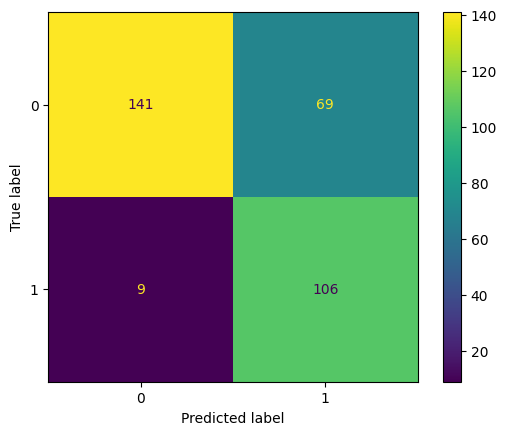

In [50]:
#Creating the classification report and a plot of the confusion matrix

from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, plot_roc_curve,roc_auc_score)
Confusion_mat2 = ConfusionMatrixDisplay(cm2)
print(classification_report(y_true, predictions3))
Confusion_mat2.plot()

# MODEL TESTING

Here we will test both the custom and pretrained model to see how well they perform

In [51]:
images = next(test_generator)

In [52]:
plt.rcParams["figure.figsize"] = (10,10)

In [55]:
labels = list(train_generator.class_indices.keys())
labels

['cracked', 'normal']

1/1 [==============================] - 0s 24ms/step


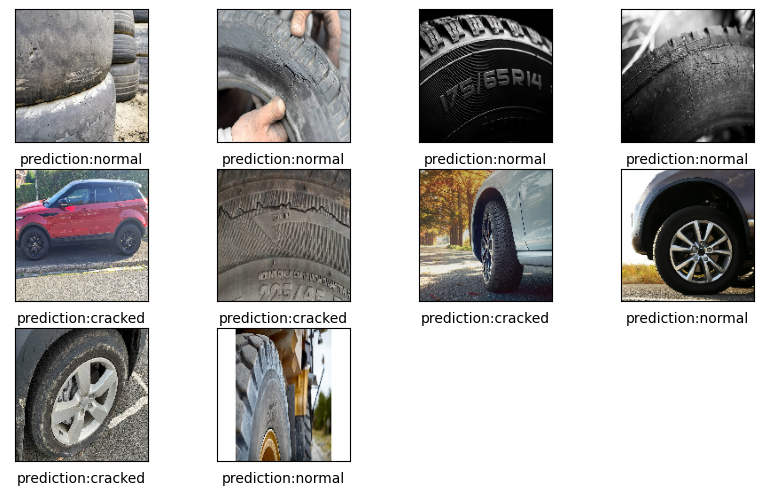

In [81]:
#custom model testing
for idx, img in enumerate(images[:10]):
    plt.subplot(5, 4, idx+1)
    pred = model.predict(np.array([img]))
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(f'prediction:{labels[np.argmax(pred)]}')
    plt.grid(visible=None)
    plt.xticks([])
    plt.yticks([])


1/1 [==============================] - 0s 105ms/step


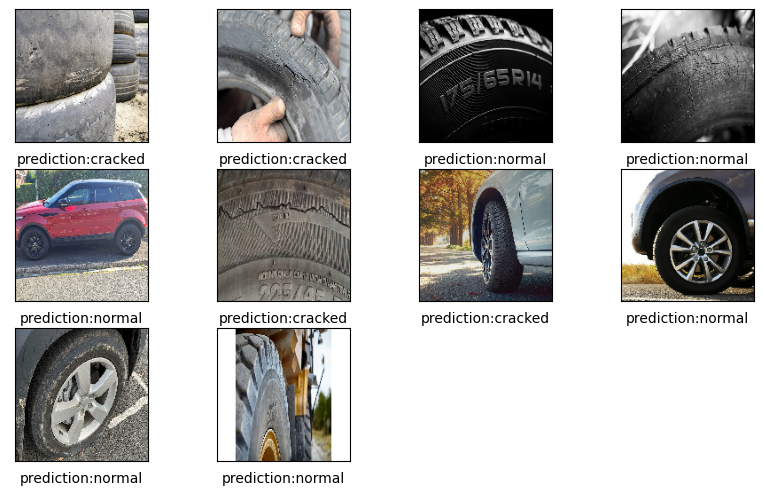

In [82]:
#VGG16 model testing
for idx, img in enumerate(images[:10]):
    plt.subplot(5, 4, idx+1)
    pred = model3.predict(np.array([img]))
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(f'prediction:{labels[np.argmax(pred)]}')
    plt.grid(visible=None)
    plt.xticks([])
    plt.yticks([])
